# Subpopulation Prediction

This notebook explores both descriptive analysis and predictive analysis of relationship estimations across subpopulations of age. The goal is to illustrate how predictions and communication patterns vary widely across different populations.

In [5]:
%matplotlib inline
import pickle
from collections import Counter
import csv
import os, sys, inspect

from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score, KFold
import shap

# Stat imports
from scipy.stats import pointbiserialr

from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2
from rpy2.robjects.packages import importr
utils = importr('utils')
 # TODO is this line still needed?
lmtest = importr('lmtest')
# https://stackoverflow.com/questions/32983365/rpy2-cannot-find-installed-external-r-packages
Hmisc = importr("Hmisc")
pandas2ri.activate()

import statsmodels.api as sm
import seaborn as sns
lowess = sm.nonparametric.lowess

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from model.model_util import *
from model.stats_util import *
from model.GroupKFoldSample import GroupKFold as GroupKFoldSample

In [6]:
predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]

replace_dict_4clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 1,
        "family_live_together": 3,
        "sig_other": 3
    }
}

replace_dict_6clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 3,
        "family_live_together": 4,
        "sig_other": 5
    }
}


contact_types_6clf = list(replace_dict_6clf['contact_type'].keys())
contact_types_4clf = ["work", "social", "task", "family_together"]

age_qlabels = ["age_q" + str(x) for x in range(1,5)]

## Load data

In [7]:
top5_all_sb_train_data = pickle.load(open('../data/final_sandbox/top5_all_train_features.df', 'rb'))
top5_all_sb_test_data = pickle.load(open('../data/final_sandbox/top5_all_test_features.df', 'rb'))

top5_all_data = pd.concat([top5_all_sb_train_data, top5_all_sb_test_data], axis=0)
top5_all_data['ego_age_q'], bins = pd.qcut(top5_all_data['ego_age'], q=4, labels=age_qlabels, retbins=True)

top5_unique = top5_all_data.drop_duplicates(subset='pid')
q_age_dict = pd.Series(top5_unique['ego_age_q'].values, index=top5_unique['pid']).to_dict()

In [8]:
top5_base_sb_train_data = pickle.load(open('../data/final_sandbox/top5_baseline_train_features.df', 'rb'))
top5_base_sb_test_data = pickle.load(open('../data/final_sandbox/top5_baseline_test_features.df', 'rb'))

#top5_base_sb_train_data = pickle.load(open('../data/final_features/all_contacts_age_gender_dedup_nan_train_features.df', 'rb'))
#top5_base_sb_test_data = pickle.load(open('../data/final_features/all_contacts_age_gender_dedup_nan_test_features.df', 'rb'))

top5_base_data = pd.concat([top5_base_sb_train_data, top5_base_sb_test_data], axis=0)
top5_base_data['ego_age_q'] = top5_base_data['pid'].map(q_age_dict)

## Build datasets

In [32]:
# build baseline data
for q in range(1,5):
    top5_base_q_train = top5_base_data.loc[top5_base_data['ego_age_q'] == "age_q{}".format(q)]
    top5_base_q_test = top5_base_data.loc[top5_base_data['ego_age_q'] != "age_q{}".format(q)]
    print(top5_base_q_train.shape)
    print(top5_base_q_test.shape)
    pickle.dump(top5_base_q_train, open("../data/subpop_features/top5_base_q{}_train_features.df".format(q), "wb"), -1)
    pickle.dump(top5_base_q_test, open("../data/subpop_features/top5_base_q{}_test_features.df".format(q), "wb"), -1)

(260, 192)
(685, 192)
(215, 192)
(730, 192)
(255, 192)
(690, 192)
(215, 192)
(730, 192)


In [33]:
# build all features data
for q in range(1,5):
    top5_all_q_train = top5_all_data.loc[top5_all_data['ego_age_q'] == "age_q{}".format(q)]
    top5_all_q_test = top5_all_data.loc[top5_all_data['ego_age_q'] != "age_q{}".format(q)]
    print(top5_all_q_train.shape)
    print(top5_all_q_test.shape)
    pickle.dump(top5_all_q_train, open("../data/subpop_features/top5_all_q{}_train_features.df".format(q), "wb"), -1)
    pickle.dump(top5_all_q_test, open("../data/subpop_features/top5_all_q{}_test_features.df".format(q), "wb"), -1)

(260, 344)
(685, 344)
(215, 344)
(730, 344)
(255, 344)
(690, 344)
(215, 344)
(730, 344)


In [16]:
# prep datasets for random forest predictions
top5_all_data = top5_all_data.replace(replace_dict_4clf)
top5_base_data = top5_base_data.replace(replace_dict_4clf)

## Descriptive Statistics

### Top 5 contacts

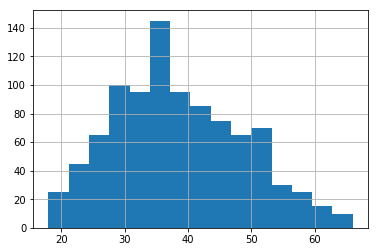

In [8]:
top5_all_data['ego_age'].hist(bins=15)

In [ ]:
quartiles = top5_all_data['ego_age'].quantile([0.25, 0.5, 0.75, 1])
terciles = top5_all_data['ego_age'].quantile([0.33, 0.67, 1])

print(quartiles)
print(terciles)

In [ ]:


print(top5_all_data['ego_age_q'].value_counts())
print(bins)

In [ ]:
print((top5_all_data['ego_age'] <= 31).sum())
print(((top5_all_data['ego_age'] <= 37) & (top5_all_data['ego_age'] > 31)).sum())
print(((top5_all_data['ego_age'] <= 46) & (top5_all_data['ego_age'] > 37)).sum())
print(((top5_all_data['ego_age'] <= 66) & (top5_all_data['ego_age'] > 46)).sum())

In [8]:
top5_all_data_one_hot = pd.concat([top5_all_data, pd.get_dummies(top5_all_data['ego_age_q'])], axis=1)

In [10]:
corr_df = top5_all_data_one_hot.drop(labels=['pid','combined_hash', 'contact_type', 'ego_age_q'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/sit

In [17]:
cols = corr_df.columns.values
age_q1_idx = np.where(cols=='age_q1')
age_q2_idx = np.where(cols=='age_q2')
age_q3_idx = np.where(cols=='age_q3')
age_q4_idx = np.where(cols=='age_q4')

### Q1

In [ ]:
q1_types = top5_all_data.loc[top5_all_data['ego_age_q'] == 'age_q1'].drop_duplicates('combined_hash')
q1_groups = q1_types.groupby('contact_type').count()
q1_groups.plot.pie('total_comms', figsize=(8,8))
plt.legend(loc='lower center')
display(q1_groups['total_comms'] / q1_groups['total_comms'].sum())

In [ ]:
age_q1_corrs = r_corrs[age_q1_idx]
age_q1_p_vals = r_p_vals[age_q1_idx]

age_q1_stats = np.transpose(np.vstack((age_q1_corrs, age_q1_p_vals)))
age_q1_df = pd.DataFrame(age_q1_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q1_df.loc[age_q1_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.sort_values(by='p')
pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q1_df.loc[age_q1_df.index.isin(contact_types_6clf)])
#display(age_q1_df.loc[age_q1_df.index.isin(contact_types_4clf)])

### Q2

contact_type
family_live_separate   0.2465
family_live_together   0.1023
friend                 0.3209
sig_other              0.1535
task                   0.1070
work                   0.0698
Name: total_comms, dtype: float64

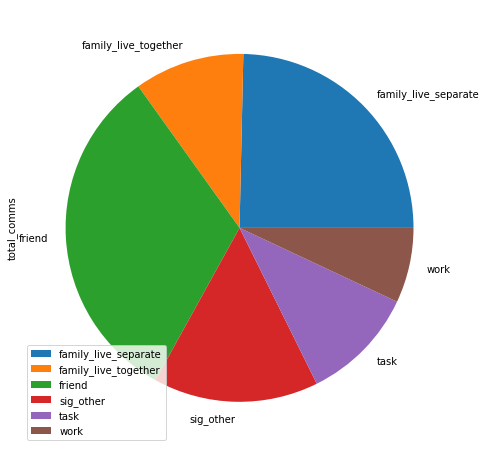

In [87]:
q2_types = top5_all_data.loc[top5_all_data['ego_age_q'] == 'age_q2'].drop_duplicates('combined_hash')
q2_groups = q2_types.groupby('contact_type').count()
q2_groups.plot.pie('total_comms', figsize=(8,8))
plt.legend(loc='lower left')
display(q2_groups['total_comms'] / q2_groups['total_comms'].sum())

In [29]:
age_q2_corrs = r_corrs[age_q2_idx]
age_q2_p_vals = r_p_vals[age_q2_idx]

age_q2_stats = np.transpose(np.vstack((age_q2_corrs, age_q2_p_vals)))
age_q2_df = pd.DataFrame(age_q2_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q2_df.loc[age_q2_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]

sig_features = sig_features.sort_values(by='p')

pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q2_df.loc[age_q2_df.index.isin(contact_types_6clf)])
#display(age_q2_df.loc[age_q2_df.index.isin(contact_types_4clf)])

,corr,p
out_sms_loc:professional/medical_office,0.2402,0.0000
all_sms_loc:professional/medical_office,0.2112,0.0000
ego_employment_other,0.1838,0.0000
ego_live_together_>=3_others,0.1783,0.0000
ego_live_together_1_other,-0.1702,0.0000
ego_ethnicity_not_hispanic,0.1555,0.0000
ego_marital_status_married,0.1555,0.0000
ego_gender_female,0.1405,0.0001
ego_gender_male,-0.1166,0.0024
ego_race_white,-0.1139,0.0032


### Q3

contact_type
family_live_separate   0.2431
family_live_together   0.1490
friend                 0.3412
sig_other              0.0980
task                   0.0863
work                   0.0824
Name: total_comms, dtype: float64

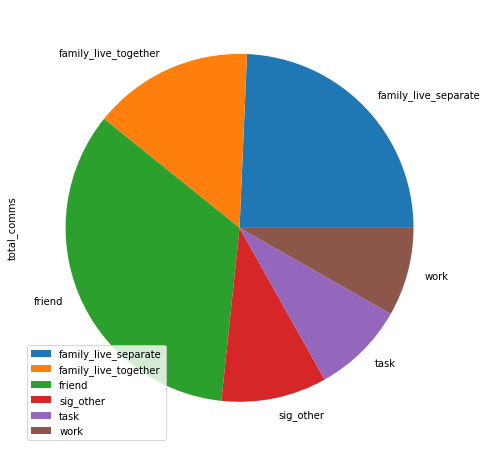

In [88]:
q3_types = top5_all_data.loc[top5_all_data['ego_age_q'] == 'age_q3'].drop_duplicates('combined_hash')
q3_groups = q3_types.groupby('contact_type').count()
q3_groups.plot.pie('total_comms', figsize=(8,8))
plt.legend(loc='lower left')
display(q3_groups['total_comms'] / q3_groups['total_comms'].sum())

In [28]:
age_q3_corrs = r_corrs[age_q3_idx]
age_q3_p_vals = r_p_vals[age_q3_idx]

age_q3_stats = np.transpose(np.vstack((age_q3_corrs, age_q3_p_vals)))
age_q3_df = pd.DataFrame(age_q3_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q3_df.loc[age_q3_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.sort_values(by='p')

pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q3_df.loc[age_q3_df.index.isin(contact_types_6clf)])
#display(age_q3_df.loc[age_q3_df.index.isin(contact_types_4clf)])

,corr,p
ego_ethnicity_hispanic,-0.2262,0.0000
ego_marital_status_single,-0.2262,0.0000
ego_marital_status_divorced,0.1784,0.0000
ego_education_completed_hs,0.1396,0.0001
ego_live_together_2_others,0.1338,0.0003
ego_marital_status_widowed,0.1200,0.0017
ego_ethnicity_not_hispanic,0.1106,0.0046
ego_marital_status_married,0.1106,0.0046
ego_education_bachelors,-0.1024,0.0102
out_call_visit_reason:errand,0.0942,0.0217


### Q4

contact_type
family_live_separate   0.2884
family_live_together   0.0930
friend                 0.2791
sig_other              0.1256
task                   0.1209
work                   0.0930
Name: total_comms, dtype: float64

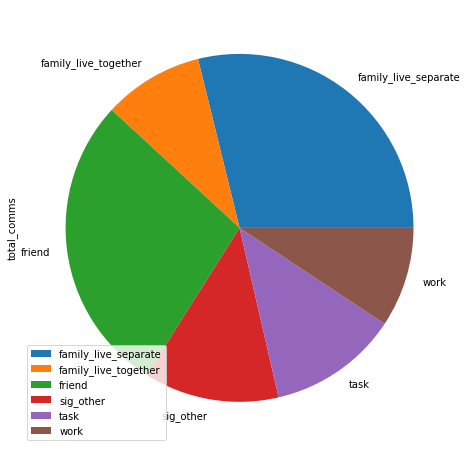

In [89]:
q4_types = top5_all_data.loc[top5_all_data['ego_age_q'] == 'age_q4'].drop_duplicates('combined_hash')
q4_groups = q4_types.groupby('contact_type').count()
q4_groups.plot.pie('total_comms', figsize=(8,8))
plt.legend(loc='lower left')
display(q4_groups['total_comms'] / q4_groups['total_comms'].sum())

In [27]:
age_q4_corrs = r_corrs[age_q4_idx]
age_q4_p_vals = r_p_vals[age_q4_idx]

age_q4_stats = np.transpose(np.vstack((age_q4_corrs, age_q4_p_vals)))
age_q4_df = pd.DataFrame(age_q4_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q4_df.loc[age_q4_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.sort_values(by='p')
pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q4_df.loc[age_q4_df.index.isin(contact_types_6clf)])
#display(age_q4_df.loc[age_q4_df.index.isin(contact_types_4clf)])

,corr,p
ego_employment_retired,0.2709,0.0000
out_sms_visit_reason:other,0.2321,0.0000
all_sms_visit_reason:other,0.2277,0.0000
ego_live_together_alone,0.1752,0.0000
call_tendency,0.1751,0.0000
ego_live_together_>=3_others,-0.1647,0.0000
ego_employment_employed,-0.1587,0.0000
all_sms_loc:home_nan_indicator,0.1565,0.0000
all_call_visit_reason:other,0.1557,0.0000
all_call_visit_reason:exercise,0.1504,0.0000


## Random Forest: top 5 baseline features age subsets

In [12]:
rand_state = 2

### Q1

In [62]:
top5_base_q1_train_data = pickle.load(open("../data/subpop_features/top5_base_q1_train_features.df", "rb"))
top5_base_q1_test_data = pickle.load(open("../data/subpop_features/top5_base_q1_test_features.df", "rb"))
    
top5_base_q1_train_data = top5_base_q1_train_data.replace(replace_dict_4clf)
top5_base_q1_train_y = top5_base_q1_train_data['contact_type']
top5_base_q1_train_X = top5_base_q1_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q1_cols = top5_base_q1_train_X.columns.values
top5_base_q1_train_X = normalize(top5_base_q1_train_X)

top5_base_q1_test_data = top5_base_q1_test_data.replace(replace_dict_4clf)
top5_base_q1_test_y = top5_base_q1_test_data['contact_type']
top5_base_q1_test_X = top5_base_q1_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q1_test_X = normalize(top5_base_q1_test_X)

top5_base_q1_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_base_q1_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_base_q1_train_X, top5_base_q1_train_y, groups):
    top5_base_q1_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_base_q1_train_X[fold_train_idx]
    fold_train_y = top5_base_q1_train_y.values[fold_train_idx]
    fold_test_X = top5_base_q1_train_X[fold_test_idx]
    fold_test_y = top5_base_q1_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_base_q1_clf.fit(fold_train_X, fold_train_y)
    predict = top5_base_q1_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({1: 141, 3: 141, 0: 141, 2: 141})
Counter({1: 138, 3: 138, 0: 138, 2: 138})
Counter({1: 137, 3: 137, 0: 137, 2: 137})
Counter({1: 142, 3: 142, 0: 142, 2: 142})
Counter({1: 142, 3: 142, 0: 142, 2: 142})
[0.6363636363636364, 0.6545454545454545, 0.7, 0.64, 0.66]
0.6581818181818182


In [29]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_base_q1_train_X, top5_base_q1_train_y)
#top5_base_q1_clf.fit(top5_base_q1_train_X, top5_base_q1_train_y)
top5_base_q1_clf.fit(X_res, y_res)
pred = top5_base_q1_clf.predict(top5_base_q1_test_X)
print_clf_metrics(top5_base_q1_test_y, pred, contact_types_4clf)

Accuracy: 0.5883211678832116


,precision,recall,F1
macro,0.517364,0.352450,0.368441
weighted,0.564940,0.588321,0.540256


,p_work,p_social,p_task,p_family_together
work,5,47,1,3
social,9,331,3,50
task,1,56,9,5
family_together,1,105,1,58


,precision,recall,F1
macro,0.517364,0.352450,0.368441
weighted,0.564940,0.588321,0.540256


In [40]:
importances = top5_base_q1_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_base_q1_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
day_5_comm,0.025194
time_of_day_2_comm,0.022479
day_5_sms,0.018863
time_of_day_5_call,0.017015
comm_last_2_wks,0.014753
time_of_day_0_comm,0.014229
time_of_day_3_comm,0.013444
time_of_day_5_call_dur,0.013109
reg_sms,0.012715
day_0_sms,0.012536


### Q2

In [63]:
top5_base_q2_train_data = pickle.load(open("../data/subpop_features/top5_base_q2_train_features.df", "rb"))
top5_base_q2_test_data = pickle.load(open("../data/subpop_features/top5_base_q2_test_features.df", "rb"))
    
top5_base_q2_train_data = top5_base_q2_train_data.replace(replace_dict_4clf)
top5_base_q2_train_y = top5_base_q2_train_data['contact_type']
top5_base_q2_train_X = top5_base_q2_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q2_cols = top5_base_q2_train_X.columns.values
top5_base_q2_train_X = normalize(top5_base_q2_train_X)

top5_base_q2_test_data = top5_base_q2_test_data.replace(replace_dict_4clf)
top5_base_q2_test_y = top5_base_q2_test_data['contact_type']
top5_base_q2_test_X = top5_base_q2_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q2_test_X = normalize(top5_base_q2_test_X)

top5_base_q2_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_base_q2_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_base_q2_train_X, top5_base_q2_train_y, groups):
    top5_base_q2_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_base_q2_train_X[fold_train_idx]
    fold_train_y = top5_base_q2_train_y.values[fold_train_idx]
    fold_test_X = top5_base_q2_train_X[fold_test_idx]
    fold_test_y = top5_base_q2_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_base_q2_clf.fit(fold_train_X, fold_train_y)
    predict = top5_base_q2_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({2: 102, 1: 102, 3: 102, 0: 102})
Counter({2: 95, 1: 95, 3: 95, 0: 95})
Counter({3: 91, 1: 91, 0: 91, 2: 91})
Counter({2: 100, 1: 100, 3: 100, 0: 100})
Counter({2: 100, 1: 100, 3: 100, 0: 100})
[0.6222222222222222, 0.5555555555555556, 0.6888888888888889, 0.65, 0.625]
0.6283333333333333


In [31]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_base_q2_train_X, top5_base_q2_train_y)
#top5_base_q2_clf.fit(top5_base_q2_train_X, top5_base_q2_train_y)
top5_base_q2_clf.fit(X_res, y_res)
pred = top5_base_q2_clf.predict(top5_base_q2_test_X)
print_clf_metrics(top5_base_q2_test_y, pred, contact_types_4clf)

Accuracy: 0.6246575342465753


,precision,recall,F1
macro,0.455670,0.414040,0.422086
weighted,0.587506,0.624658,0.599138


,p_work,p_social,p_task,p_family_together
work,4,42,7,7
social,10,362,17,57
task,2,30,22,7
family_together,2,86,7,68


,precision,recall,F1
macro,0.455670,0.414040,0.422086
weighted,0.587506,0.624658,0.599138


In [43]:
importances = top5_base_q2_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_base_q2_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
comm_last_6_wks,0.019477
day_1_comm,0.018000
day_2_comm,0.017775
day_4_long_call_out,0.015665
out_comm,0.015328
mean_out_sms,0.015023
total_comms,0.014968
time_of_day_5_sms,0.014705
day_0_comm,0.014656
comm_last_2_wks,0.014579


### Q3

In [64]:
top5_base_q3_train_data = pickle.load(open("../data/subpop_features/top5_base_q3_train_features.df", "rb"))
top5_base_q3_test_data = pickle.load(open("../data/subpop_features/top5_base_q3_test_features.df", "rb"))
    
top5_base_q3_train_data = top5_base_q3_train_data.replace(replace_dict_4clf)
top5_base_q3_train_y = top5_base_q3_train_data['contact_type']
top5_base_q3_train_X = top5_base_q3_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q3_cols = top5_base_q3_train_X.columns.values
top5_base_q3_train_X = normalize(top5_base_q3_train_X)

top5_base_q3_test_data = top5_base_q3_test_data.replace(replace_dict_4clf)
top5_base_q3_test_y = top5_base_q3_test_data['contact_type']
top5_base_q3_test_X = top5_base_q3_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q3_test_X = normalize(top5_base_q3_test_X)

top5_base_q3_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_base_q3_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_base_q3_train_X, top5_base_q3_train_y, groups):
    top5_base_q3_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_base_q3_train_X[fold_train_idx]
    fold_train_y = top5_base_q3_train_y.values[fold_train_idx]
    fold_test_X = top5_base_q3_train_X[fold_test_idx]
    fold_test_y = top5_base_q3_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_base_q3_clf.fit(fold_train_X, fold_train_y)
    predict = top5_base_q3_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({3: 118, 1: 118, 2: 118, 0: 118})
Counter({1: 120, 3: 120, 2: 120, 0: 120})
Counter({1: 118, 3: 118, 0: 118, 2: 118})
Counter({1: 116, 3: 116, 2: 116, 0: 116})
Counter({1: 124, 3: 124, 2: 124, 0: 124})
[0.5272727272727272, 0.56, 0.6, 0.6, 0.56]
0.5694545454545455


In [34]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_base_q3_train_X, top5_base_q3_train_y)
#top5_base_q3_clf.fit(top5_base_q3_train_X, top5_base_q3_train_y)
top5_base_q3_clf.fit(X_res, y_res)
pred = top5_base_q3_clf.predict(top5_base_q3_test_X)
print_clf_metrics(top5_base_q3_test_y, pred, contact_types_4clf)

Accuracy: 0.6420289855072464


,precision,recall,F1
macro,0.503565,0.431139,0.449568
weighted,0.603693,0.642029,0.611547


,p_work,p_social,p_task,p_family_together
work,4,44,0,6
social,9,355,14,41
task,1,24,27,10
family_together,3,90,5,57


,precision,recall,F1
macro,0.503565,0.431139,0.449568
weighted,0.603693,0.642029,0.611547


In [45]:
importances = top5_base_q3_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_base_q3_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
time_of_day_4_comm_out,0.028062
in_out_sms,0.024481
time_of_day_5_comm,0.019158
mean_out_sms,0.017290
time_of_day_4_call_dur,0.016039
max_out_sms,0.015719
med_out_sms,0.014407
std_out_sms,0.013889
total_sms_days,0.013441
total_calls,0.013373


### Q4

In [65]:
top5_base_q4_train_data = pickle.load(open("../data/subpop_features/top5_base_q4_train_features.df", "rb"))
top5_base_q4_test_data = pickle.load(open("../data/subpop_features/top5_base_q4_test_features.df", "rb"))
    
top5_base_q4_train_data = top5_base_q4_train_data.replace(replace_dict_4clf)
top5_base_q4_train_y = top5_base_q4_train_data['contact_type']
top5_base_q4_train_X = top5_base_q4_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q4_cols = top5_base_q4_train_X.columns.values
top5_base_q4_train_X = normalize(top5_base_q4_train_X)

top5_base_q4_test_data = top5_base_q4_test_data.replace(replace_dict_4clf)
top5_base_q4_test_y = top5_base_q4_test_data['contact_type']
top5_base_q4_test_X = top5_base_q4_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q4_test_X = normalize(top5_base_q4_test_X)

top5_base_q4_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_base_q4_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_base_q4_train_X, top5_base_q4_train_y, groups):
    top5_base_q4_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_base_q4_train_X[fold_train_idx]
    fold_train_y = top5_base_q4_train_y.values[fold_train_idx]
    fold_test_X = top5_base_q4_train_X[fold_test_idx]
    fold_test_y = top5_base_q4_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_base_q4_clf.fit(fold_train_X, fold_train_y)
    predict = top5_base_q4_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({1: 94, 2: 94, 0: 94, 3: 94})
Counter({1: 100, 2: 100, 0: 100, 3: 100})
Counter({0: 85, 3: 85, 1: 85, 2: 85})
Counter({1: 102, 2: 102, 0: 102, 3: 102})
Counter({1: 107, 2: 107, 3: 107, 0: 107})
[0.4666666666666667, 0.6666666666666666, 0.7111111111111111, 0.5, 0.5]
0.5688888888888889


In [66]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_base_q4_train_X, top5_base_q4_train_y)
#top5_base_q4_clf.fit(top5_base_q4_train_X, top5_base_q4_train_y)
top5_base_q4_clf.fit(X_res, y_res)
pred = top5_base_q4_clf.predict(top5_base_q4_test_X)
print_clf_metrics(top5_base_q4_test_y, pred, contact_types_4clf)

Accuracy: 0.6506849315068494


,precision,recall,F1
macro,0.519848,0.429451,0.452711
weighted,0.617493,0.650685,0.622608


,p_work,p_social,p_task,p_family_together
work,4,47,2,2
social,7,374,10,55
task,2,31,21,4
family_together,3,89,3,76


,precision,recall,F1
macro,0.519848,0.429451,0.452711
weighted,0.617493,0.650685,0.622608


In [48]:
importances = top5_base_q4_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_base_q4_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
med_out_sms,0.025628
in_out_sms_nan_indicator,0.020123
mean_out_sms,0.019721
max_out_sms,0.019173
time_of_day_5_comm,0.016918
time_of_day_5_comm_out,0.016407
sms_last_6_wks,0.015913
std_out_sms,0.014724
time_of_day_5_call,0.013471
time_of_day_0_sms_nan_indicator,0.012568


## Random Forest: top 5 all features age subsets

### Q1

In [50]:
top5_all_q1_train_data = pickle.load(open("../data/subpop_features/top5_all_q1_train_features.df", "rb"))
top5_all_q1_test_data = pickle.load(open("../data/subpop_features/top5_all_q1_test_features.df", "rb"))
    
top5_all_q1_train_data = top5_all_q1_train_data.replace(replace_dict_4clf)
top5_all_q1_train_y = top5_all_q1_train_data['contact_type']
top5_all_q1_train_X = top5_all_q1_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q1_cols = top5_all_q1_train_X.columns.values
top5_all_q1_train_X = normalize(top5_all_q1_train_X)

top5_all_q1_test_data = top5_all_q1_test_data.replace(replace_dict_4clf)
top5_all_q1_test_y = top5_all_q1_test_data['contact_type']
top5_all_q1_test_X = top5_all_q1_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q1_test_X = normalize(top5_all_q1_test_X)

top5_all_q1_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_all_q1_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_all_q1_train_X, top5_all_q1_train_y, groups):
    top5_all_q1_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_all_q1_train_X[fold_train_idx]
    fold_train_y = top5_all_q1_train_y.values[fold_train_idx]
    fold_test_X = top5_all_q1_train_X[fold_test_idx]
    fold_test_y = top5_all_q1_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_all_q1_clf.fit(fold_train_X, fold_train_y)
    predict = top5_all_q1_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({1: 141, 3: 141, 0: 141, 2: 141})
Counter({1: 138, 3: 138, 0: 138, 2: 138})
Counter({1: 137, 3: 137, 0: 137, 2: 137})
Counter({1: 142, 3: 142, 0: 142, 2: 142})
Counter({1: 142, 3: 142, 0: 142, 2: 142})
[0.6181818181818182, 0.6909090909090909, 0.7, 0.66, 0.68]
0.6698181818181819


In [51]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_all_q1_train_X, top5_all_q1_train_y)
#top5_all_q1_clf.fit(top5_all_q1_train_X, top5_all_q1_train_y)
top5_all_q1_clf.fit(X_res, y_res)
pred = top5_all_q1_clf.predict(top5_all_q1_test_X)
print_clf_metrics(top5_all_q1_test_y, pred, contact_types_4clf)

Accuracy: 0.5941605839416059


,precision,recall,F1
macro,0.604833,0.334600,0.343225
weighted,0.596563,0.594161,0.529817


,p_work,p_social,p_task,p_family_together
work,4,51,0,1
social,3,348,0,42
task,0,61,6,4
family_together,2,113,1,49


,precision,recall,F1
macro,0.604833,0.334600,0.343225
weighted,0.596563,0.594161,0.529817


In [52]:
importances = top5_all_q1_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_all_q1_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
day_0_comm_out,0.021391
time_of_day_2_sms,0.017757
day_5_comm,0.016163
time_of_day_3_comm,0.015754
time_of_day_0_miss_call_out_nan_indicator,0.014721
ego_age,0.014111
ego_employment_employed,0.013253
all_sms_loc:work,0.013180
out_comm,0.012359
total_comm_days,0.011009


### Q2

In [53]:
top5_all_q2_train_data = pickle.load(open("../data/subpop_features/top5_all_q2_train_features.df", "rb"))
top5_all_q2_test_data = pickle.load(open("../data/subpop_features/top5_all_q2_test_features.df", "rb"))
    
top5_all_q2_train_data = top5_all_q2_train_data.replace(replace_dict_4clf)
top5_all_q2_train_y = top5_all_q2_train_data['contact_type']
top5_all_q2_train_X = top5_all_q2_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q2_cols = top5_all_q2_train_X.columns.values
top5_all_q2_train_X = normalize(top5_all_q2_train_X)

top5_all_q2_test_data = top5_all_q2_test_data.replace(replace_dict_4clf)
top5_all_q2_test_y = top5_all_q2_test_data['contact_type']
top5_all_q2_test_X = top5_all_q2_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q2_test_X = normalize(top5_all_q2_test_X)

top5_all_q2_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_all_q2_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_all_q2_train_X, top5_all_q2_train_y, groups):
    top5_all_q2_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_all_q2_train_X[fold_train_idx]
    fold_train_y = top5_all_q2_train_y.values[fold_train_idx]
    fold_test_X = top5_all_q2_train_X[fold_test_idx]
    fold_test_y = top5_all_q2_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_all_q2_clf.fit(fold_train_X, fold_train_y)
    predict = top5_all_q2_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({2: 102, 1: 102, 3: 102, 0: 102})
Counter({2: 95, 1: 95, 3: 95, 0: 95})
Counter({3: 91, 1: 91, 0: 91, 2: 91})
Counter({2: 100, 1: 100, 3: 100, 0: 100})
Counter({2: 100, 1: 100, 3: 100, 0: 100})
[0.6444444444444445, 0.6222222222222222, 0.7333333333333333, 0.7, 0.55]
0.65


In [54]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_all_q2_train_X, top5_all_q2_train_y)
#top5_all_q2_clf.fit(top5_all_q2_train_X, top5_all_q2_train_y)
top5_all_q2_clf.fit(X_res, y_res)
pred = top5_all_q2_clf.predict(top5_all_q2_test_X)
print_clf_metrics(top5_all_q2_test_y, pred, contact_types_4clf)

Accuracy: 0.6438356164383562


,precision,recall,F1
macro,0.481830,0.411824,0.425458
weighted,0.599436,0.643836,0.609815


,p_work,p_social,p_task,p_family_together
work,3,46,4,7
social,6,381,10,49
task,2,28,21,10
family_together,2,89,7,65


,precision,recall,F1
macro,0.481830,0.411824,0.425458
weighted,0.599436,0.643836,0.609815


In [55]:
importances = top5_all_q2_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_all_q2_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
day_0_comm,0.014703
comm_last_2_wks,0.013468
ego_age,0.013281
day_2_comm,0.013258
comm_last_6_wks,0.011368
ego_employment_employed,0.010934
all_sms_visit_reason:home,0.010852
time_of_day_2_sms,0.010748
tot_call_duration,0.010714
day_3_comm,0.010673


### Q3

In [56]:
top5_all_q3_train_data = pickle.load(open("../data/subpop_features/top5_all_q3_train_features.df", "rb"))
top5_all_q3_test_data = pickle.load(open("../data/subpop_features/top5_all_q3_test_features.df", "rb"))
    
top5_all_q3_train_data = top5_all_q3_train_data.replace(replace_dict_4clf)
top5_all_q3_train_y = top5_all_q3_train_data['contact_type']
top5_all_q3_train_X = top5_all_q3_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q3_cols = top5_all_q3_train_X.columns.values
top5_all_q3_train_X = normalize(top5_all_q3_train_X)

top5_all_q3_test_data = top5_all_q3_test_data.replace(replace_dict_4clf)
top5_all_q3_test_y = top5_all_q3_test_data['contact_type']
top5_all_q3_test_X = top5_all_q3_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q3_test_X = normalize(top5_all_q3_test_X)

top5_all_q3_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_all_q3_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_all_q3_train_X, top5_all_q3_train_y, groups):
    top5_all_q3_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_all_q3_train_X[fold_train_idx]
    fold_train_y = top5_all_q3_train_y.values[fold_train_idx]
    fold_test_X = top5_all_q3_train_X[fold_test_idx]
    fold_test_y = top5_all_q3_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_all_q3_clf.fit(fold_train_X, fold_train_y)
    predict = top5_all_q3_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({3: 118, 1: 118, 2: 118, 0: 118})
Counter({1: 120, 3: 120, 2: 120, 0: 120})
Counter({1: 118, 3: 118, 0: 118, 2: 118})
Counter({1: 116, 3: 116, 2: 116, 0: 116})
Counter({1: 124, 3: 124, 2: 124, 0: 124})
[0.5454545454545454, 0.58, 0.64, 0.66, 0.58]
0.6010909090909091


In [57]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_all_q3_train_X, top5_all_q3_train_y)
#top5_all_q3_clf.fit(top5_all_q3_train_X, top5_all_q3_train_y)
top5_all_q3_clf.fit(X_res, y_res)
pred = top5_all_q3_clf.predict(top5_all_q3_test_X)
print_clf_metrics(top5_all_q3_test_y, pred, contact_types_4clf)

Accuracy: 0.6550724637681159


,precision,recall,F1
macro,0.517094,0.431460,0.453036
weighted,0.616903,0.655072,0.619580


,p_work,p_social,p_task,p_family_together
work,3,42,2,7
social,12,366,11,30
task,1,30,27,4
family_together,1,95,3,56


,precision,recall,F1
macro,0.517094,0.431460,0.453036
weighted,0.616903,0.655072,0.619580


In [58]:
importances = top5_all_q3_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_all_q3_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
mean_out_sms,0.016040
time_of_day_4_comm_out,0.013897
in_out_sms,0.013846
time_of_day_4_comm,0.013149
time_of_day_4_call_dur,0.012262
med_out_sms,0.011625
total_sms_days,0.011616
out_sms_loc:work,0.011438
std_out_sms,0.009395
time_of_day_5_comm,0.009197


### Q4

In [59]:
top5_all_q4_train_data = pickle.load(open("../data/subpop_features/top5_all_q4_train_features.df", "rb"))
top5_all_q4_test_data = pickle.load(open("../data/subpop_features/top5_all_q4_test_features.df", "rb"))
    
top5_all_q4_train_data = top5_all_q4_train_data.replace(replace_dict_4clf)
top5_all_q4_train_y = top5_all_q4_train_data['contact_type']
top5_all_q4_train_X = top5_all_q4_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q4_cols = top5_all_q4_train_X.columns.values
top5_all_q4_train_X = normalize(top5_all_q4_train_X)

top5_all_q4_test_data = top5_all_q4_test_data.replace(replace_dict_4clf)
top5_all_q4_test_y = top5_all_q4_test_data['contact_type']
top5_all_q4_test_X = top5_all_q4_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q4_test_X = normalize(top5_all_q4_test_X)

top5_all_q4_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_all_q4_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_all_q4_train_X, top5_all_q4_train_y, groups):
    top5_all_q4_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_all_q4_train_X[fold_train_idx]
    fold_train_y = top5_all_q4_train_y.values[fold_train_idx]
    fold_test_X = top5_all_q4_train_X[fold_test_idx]
    fold_test_y = top5_all_q4_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_all_q4_clf.fit(fold_train_X, fold_train_y)
    predict = top5_all_q4_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({1: 94, 2: 94, 0: 94, 3: 94})
Counter({1: 100, 2: 100, 0: 100, 3: 100})
Counter({0: 85, 3: 85, 1: 85, 2: 85})
Counter({1: 102, 2: 102, 0: 102, 3: 102})
Counter({1: 107, 2: 107, 3: 107, 0: 107})
[0.4666666666666667, 0.6222222222222222, 0.7333333333333333, 0.5, 0.5]
0.5644444444444445


In [60]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_all_q4_train_X, top5_all_q4_train_y)
#top5_all_q4_clf.fit(top5_all_q4_train_X, top5_all_q4_train_y)
top5_all_q4_clf.fit(X_res, y_res)
pred = top5_all_q4_clf.predict(top5_all_q4_test_X)
print_clf_metrics(top5_all_q4_test_y, pred, contact_types_4clf)

Accuracy: 0.6506849315068494


,precision,recall,F1
macro,0.481406,0.401884,0.416580
weighted,0.601024,0.650685,0.610702


,p_work,p_social,p_task,p_family_together
work,1,45,3,6
social,2,388,8,48
task,3,32,19,4
family_together,1,99,4,67


,precision,recall,F1
macro,0.481406,0.401884,0.416580
weighted,0.601024,0.650685,0.610702


In [61]:
importances = top5_all_q4_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_all_q4_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
mean_out_sms,0.020111
in_out_sms_nan_indicator,0.019749
med_out_sms,0.018101
max_out_sms,0.014945
std_out_sms,0.013375
time_of_day_5_comm_out,0.011221
reg_sms,0.010781
std_out_sms_nan_indicator,0.009747
total_sms,0.009604
total_sms_days,0.009601


## Feature analysis

- Cohen's d
- Spearman correlation for age
- t-test for significance
- violin plot (group box plot):
    - gender split
- scatter plot per contact type (loess plot):
    - y is contact frequency, x is age
- try 10-fold CV